In [ ]:
!pip install tensorflow==2.9.1 tensorflow-gpu==2.9.1 tensorflow-hub opencv-python matplotlib

In [1]:
# Import TF and TF Hub libraries.
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
import time

# Download the model from TF Hub.
model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = model.signatures['serving_default']

In [2]:
#keypoints_with_scores.shape = [6,17,3]
#6 persons, 17 keypoints, 3 numbers = [y coor, x coord, confident]
#keypoint = [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle]

def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

In [3]:
def face_angle(frame, keypoints,confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    #middle_eartoear(x,y) = (middle_eartoear[1],middle_eartoear[0])
    #nose(x,y) = (shaped[0][1],shaped[0][0])
    middle_eartoear = (shaped[4] + shaped[3])/2
    vector_len = math.dist(middle_eartoear[:2],shaped[0][:2])
    temp_x = (shaped[0][1]-middle_eartoear[1])/vector_len
    temp_y = (shaped[0][0]-middle_eartoear[0])/vector_len
    face_angle = math.degrees(math.acos(temp_x))
    
    if shaped[0][0] > middle_eartoear[0]:
        face_angle = -face_angle+360
    
    if shaped[3][1] < shaped[4][1]: #หน้าหลัง
        back_or_front = 'Back'
    elif shaped[3][1] >= shaped[4][1]:
        back_or_front = 'Front'

    vector_len_threshold = 7
    if vector_len < vector_len_threshold:
        look_udlr = ' '
    elif vector_len >= vector_len_threshold:
        if (0 < face_angle < 45) or (315 < face_angle < 360):
            look_udlr = 'Right'
        elif (45 < face_angle < 135):
            look_udlr = 'Up'
        elif (135 < face_angle < 225):
            look_udlr = 'Left'
        elif (225 < face_angle < 315):
            look_udlr = 'Down'
    
    if (shaped[4][2] > confidence_threshold) & (shaped[3][2] > confidence_threshold) & (shaped[0][2] > confidence_threshold):
        cv2.putText(frame,back_or_front+'('+str(int(vector_len))+', '+str(int(face_angle))+')', (int(middle_eartoear[1]+5),int(middle_eartoear[0]+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),2)
        cv2.putText(frame,back_or_front+' '+look_udlr, (int(middle_eartoear[1]),int(middle_eartoear[0])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)

In [4]:
#Connect key point

EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)

In [5]:
#Draw arrow for head direction
def draw_head_direction(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    if (shaped[3][2] > confidence_threshold) & (shaped[4][2] > confidence_threshold) & (shaped[0][2] > confidence_threshold):      
        middle_eartoear = (shaped[4] + shaped[3])/2
        cv2.arrowedLine(frame, (int(middle_eartoear[1]), int(middle_eartoear[0])), (int(shaped[0][1]), int(shaped[0][0])), (0,0,255), 2)
        #cv2.arrowedLine(frame, (int(middle_eartoear[1]), int(middle_eartoear[0])), (int(shaped[3][1]), int(shaped[3][0])), (0,0,255), 2)

In [33]:
# Function to loop through each person detected and render

def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        #draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)
        draw_head_direction(frame, person, edges, confidence_threshold)
        #face_angle(frame, person, confidence_threshold)

In [7]:
def fps_counter(frame,start,end):
    fps = 1.0 / (end - start)
    cv2.putText(frame,'FPS: '+str("{:.2f}".format(fps)),(0,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0),3)

In [ ]:
cap = cv2.VideoCapture('Test 8.mp4')

w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS) 
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (int(w),int(h)))

while cap.isOpened():
    
    fps_counter_start_time = time.time()
    
    # Read frame from cap
    ret, frame = cap.read()
    
    (h,w) = frame.shape[:2]
    centerX,centerY = (w//2),(h//2)
    topLeft = frame[0:centerY,0:centerX]
    topRight = frame[0:centerY,centerX:w]
    bottomLeft = frame[centerY:h,0:centerX]
    bottomRight = frame[centerY:h,centerX:w]
    
    splitted_frame = [topLeft,topRight,bottomLeft,bottomRight]
    marked_splitted_frame = []
    
    for frame in splitted_frame:
        # Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)

        # Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, EDGES, 0.3)
        
        marked_splitted_frame.append(frame)

    topLeftRight = np.hstack((marked_splitted_frame[0],marked_splitted_frame[1]))
    bottomLeftRight = np.hstack((marked_splitted_frame[2],marked_splitted_frame[3]))
    frame = np.vstack((topLeftRight,bottomLeftRight))
        
    fps_counter_end_time = time.time()
    fps_counter(frame,fps_counter_start_time,fps_counter_end_time)

    out.write(frame)
    cv2.imshow('Movenet Multipose', frame)

    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

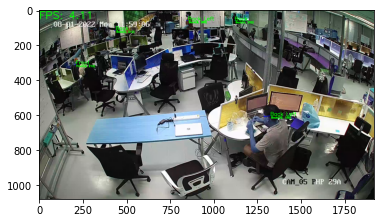

In [28]:
(h,w) = frame.shape[:2]
centerX,centerY = (w//2),(h//2)
topLeft = frame[0:centerY,0:centerX]
topRight = frame[0:centerY,centerX:w]
bottomLeft = frame[centerY:h,0:centerX]
bottomRight = frame[centerY:h,centerX:w]
topLeftRight = np.hstack((topLeft,topRight))
bottomLeftRight = np.hstack((bottomLeft,bottomRight))
fullimg = np.vstack((topLeftRight,bottomLeftRight))
plt.imshow(fullimg)

In [ ]:
cap.release()
out.release()
cv2.destroyAllWindows()